# Basic PEMtk fitting class demo

03/06/21

Tidy version for docs, derived from http://127.0.0.1:8888/lab/tree/dev/PEMtk/fitting/fitting_routines_class-demo_v1_110521-tidy-StimpyTest_020621.ipynb


11/05/21

First version of class test/demo.

See [dev notebook](http://127.0.0.1:8888/lab/tree/dev/PEMtk/fitting/fitting_routines_dev_PEMtk_300421.ipynb) for background.

Outline of this notebook:

- Load required packages.
- Setup pemtkFit object.
   - Set various parameters, either from existing data or new values.
   - Data is handled as a set of dictionaries within the class, `self.data[key][dataType]`, where `key` is an arbitrary label for, e.g. a specific experiment, calculation etc, and `dataType` contains a set of values, parameters etc. (Should become clear below!)
   - Methods operate on all `self.data` items in general, with some special cases: `self.data['subset']` contains data to be used in fitting.
- Simulate data
   - Use ePSproc to simulated aligned-frame measurements.
- Fit data

### Prerequisities

- Working installation of [ePSproc](https://github.com/phockett/ePSproc) + [PEMtk](https://github.com/phockett/PEMtk) (or local copies of the Git repos, which can be pointed at for setup below).
- Test/demo data, from [ePSproc Github repo](https://github.com/phockett/ePSproc/tree/master/data/photoionization/).

## Setup

### Imports

A few standard imports...

In [1]:
import sys
import os
from pathlib import Path
# import numpy as np
# import epsproc as ep
# import xarray as xr

from datetime import datetime as dt
timeString = dt.now()

And local module imports. This should work either for installed versions (e.g. via `pip install`), or for test code via setting the base path below to point at your local copies.

In [2]:
# For module testing, include path to module here, otherwise use global installation
if sys.platform == "win32":
    modPath = Path(r'D:\code\github')  # Win test machine
    winFlag = True
else:
    modPath = Path(r'/home/femtolab/github')  # Linux test machine
    winFlag = False
    
# Append to sys path
sys.path.append((modPath/'ePSproc').as_posix())
sys.path.append((modPath/'PEMtk').as_posix())

In [3]:
# ePSproc
import epsproc as ep

# Set data path
# Note this is set here from ep.__path__, but may not be correct in all cases - depends on where the Github repo is.
epDemoDataPath = Path(ep.__path__[0]).parent/'data'

In [4]:
# PEMtk
# import pemtk as pm
# from pemtk.data.dataClasses import dataClass

# Import fitting class
from pemtk.fit.fitClass import pemtkFit

In [5]:
# Set HTML output style for Xarray in notebooks (optional), may also depend on version of Jupyter notebook or lab, or Xr
# See http://xarray.pydata.org/en/stable/generated/xarray.set_options.html
# if isnotebook():
# xr.set_options(display_style = 'html')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
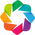

In [6]:
# Set some plot options
ep.plot.hvPlotters.setPlotters()

### Set & load parameters

There are a few things that need to be configured for a given case...

- Matrix elements (or (l,m,mu) indicies) to use.
- Alignment distribution (ADMs).
- Polarization geometry.

In this demo, a real case will first be simulated with computational values, and then used to test the fitting routines.

(TODO: demo from scratch without known matrix elements.)

#### Matrix elements

For fit testing, start with computational values for the matrix elements. These will be used to simulate data, and also to provide a list of parameters to fit later.

In [7]:
# Set for ePSproc test data, available from https://github.com/phockett/ePSproc/tree/master/data
# Note this is set here from ep.__path__, but may not be correct in all cases.

# Multiorb data
dataPath = os.path.join(epDemoDataPath, 'photoionization', 'n2_multiorb')

In [8]:
data = pemtkFit(fileBase = dataPath, verbose = 1)

In [9]:
# Read data files
data.scanFiles()
data.jobsSummary()


*** Job orb6 details
Key: orb6
Dir D:\code\github\ePSproc\data\photoionization\n2_multiorb, 1 file(s).
{   'batch': 'ePS n2, batch n2_1pu_0.1-50.1eV, orbital A2',
    'event': ' N2 A-state (1piu-1)',
    'orbE': -17.096913836366,
    'orbLabel': '1piu-1'}

*** Job orb5 details
Key: orb5
Dir D:\code\github\ePSproc\data\photoionization\n2_multiorb, 1 file(s).
{   'batch': 'ePS n2, batch n2_3sg_0.1-50.1eV, orbital A2',
    'event': ' N2 X-state (3sg-1)',
    'orbE': -17.341816310545997,
    'orbLabel': '3sg-1'}

*** Job orb6 details
Key: orb6
Dir D:\code\github\ePSproc\data\photoionization\n2_multiorb, 1 file(s).
{   'batch': 'ePS n2, batch n2_1pu_0.1-50.1eV, orbital A2',
    'event': ' N2 A-state (1piu-1)',
    'orbE': -17.096913836366,
    'orbLabel': '1piu-1'}

*** Job orb5 details
Key: orb5
Dir D:\code\github\ePSproc\data\photoionization\n2_multiorb, 1 file(s).
{   'batch': 'ePS n2, batch n2_3sg_0.1-50.1eV, orbital A2',
    'event': ' N2 X-state (3sg-1)',
    'orbE': -17.341816310545

#### Alignment distribution moments (ADMs)

The class [wraps ep.setADMs()](https://epsproc.readthedocs.io/en/dev/modules/epsproc.sphCalc.html#epsproc.sphCalc.setADMs). This returns an isotropic distribution by default, or values can be set explicitly from a list. Values are set in `self.data['ADM']`.

Note: if this is not set, the default value will be used, which is likely not very useful for the fit!

In [10]:
# Default case
data.setADMs()
# data.ADM['ADMX']
data.data['ADM']['ADM']

<xarray.DataArray 'ADM' (ADM: 1, t: 1)>
array([[1]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0
  - Q        (ADM) int64 0
  - S        (ADM) int64 0
  * t        (t) int32 0
Attributes:
    dataType:   ADM
    long_name:  Axis distribution moments
    units:      arb

In [11]:
# Load time-dependent ADMs for N2 case
# Adapted from ePSproc_AFBLM_testing_010519_300719.m

from scipy.io import loadmat
ADMdataFile = os.path.join(epDemoDataPath, 'alignment', 'N2_ADM_VM_290816.mat')
ADMs = loadmat(ADMdataFile)

# Set tOffset for calcs, 3.76ps!!!
# This is because this is 2-pulse case, and will set t=0 to 2nd pulse (and matches defn. in N2 experimental paper)
tOffset = -3.76
ADMs['time'] = ADMs['time'] + tOffset

data.setADMs(ADMs = ADMs['ADM'], t=ADMs['time'].squeeze(), KQSLabels = ADMs['ADMlist'], addS = True)
data.data['ADM']['ADM']

<xarray.DataArray 'ADM' (ADM: 4, t: 3691)>
array([[ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j, ...,
         1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         1.00000000e+00+0.00000000e+00j],
       [-2.26243113e-17+0.00000000e+00j,  2.43430608e-08+1.04125246e-20j,
         9.80188266e-08+6.89166168e-20j, ...,
         1.05433798e-01-1.62495135e-18j,  1.05433798e-01-1.62495135e-18j,
         1.05433798e-01-1.62495135e-18j],
       [ 1.55724057e-16+0.00000000e+00j, -3.37021111e-10-6.81416260e-20j,
         1.95424253e-10-3.10513374e-19j, ...,
         8.39913132e-02-5.12795441e-17j,  8.39913132e-02-5.12795441e-17j,
         8.39913132e-02-5.12795441e-17j],
       [-7.68430227e-16+0.00000000e+00j, -1.40177466e-11+1.04987400e-19j,
         6.33419102e-10+1.74747003e-18j, ...,
         3.78131657e-02+4.01318983e-16j,  3.78131657e-02+4.01318983e-16j,
         3.78131657e-02+4.01318983e-16j]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0 2 4 6
  - Q        (ADM) int64 0 0 0 0
  - S        (ADM) int64 0 0 0 0
  * t        (t) float64 -3.76 -3.76 -3.76 -3.759 -3.759 ... 10.1 10.1 10.1 10.1
Attributes:
    dataType:   ADM
    long_name:  Axis distribution moments
    units:      arb

Dataset: ADM, ADM


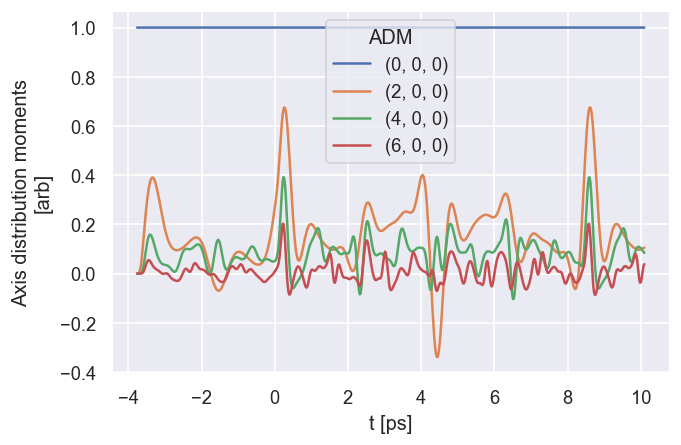

In [12]:
# The ADMplot routine will show a basic line plot, note it needs keys = 'ADM' in the current implementation (otherwise will loop over all keys)
data.ADMplot(keys = 'ADM')

Plotting data (No filename), pType=a, thres=0.01, with Seaborn


No handles with labels found to put in legend.


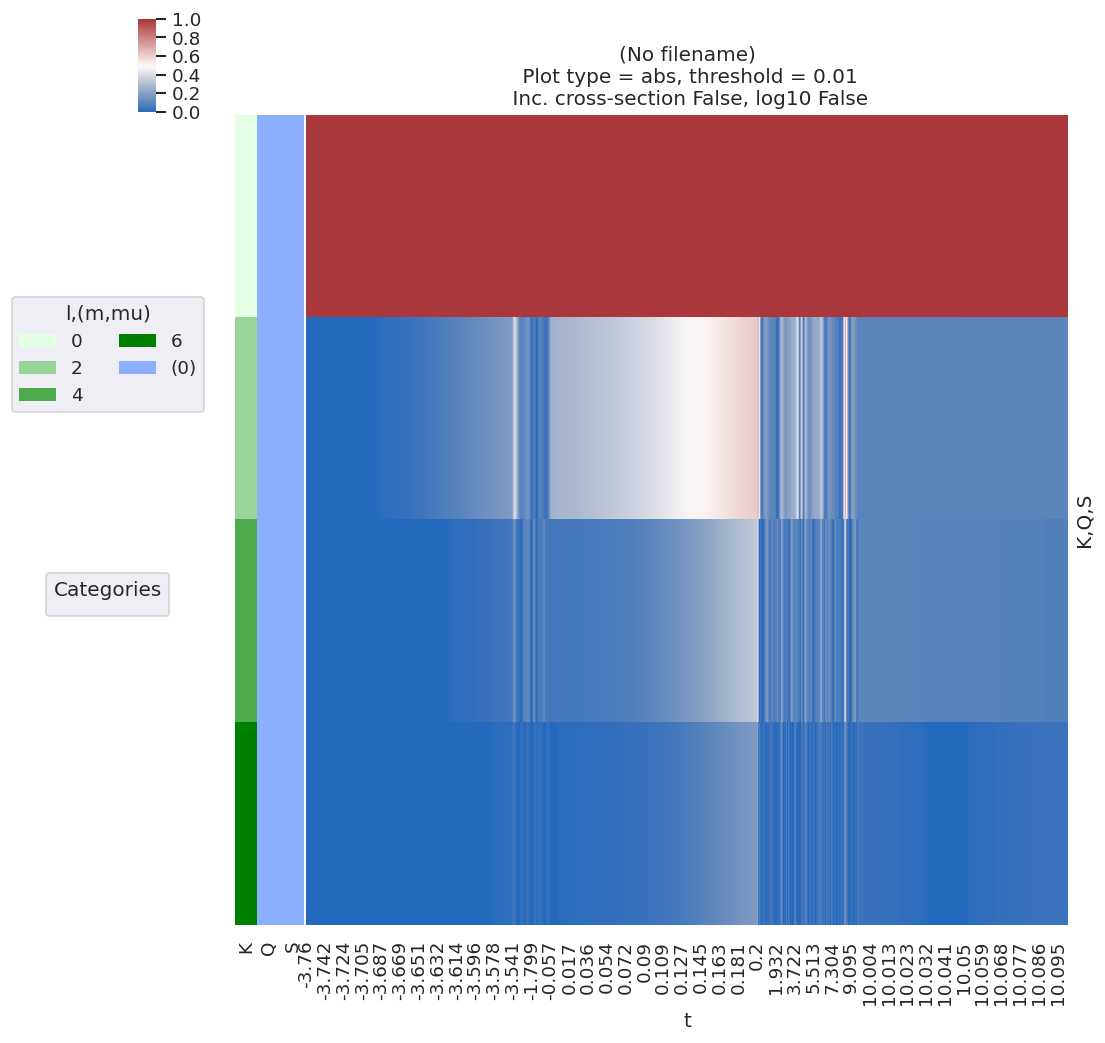

In [13]:
# lmPlot is also handy, it minimally needs the correct keys, dataType and xDim specified

# data.lmPlot(keys = 'ADM', dataType = 'ADM', xDim = 't')  # Minimal call

data.lmPlot(keys = 'ADM', dataType = 'ADM', xDim = 't', fillna = True, logFlag = False, cmap = 'vlag')  # Set some additional options

### Polarisation geometry/ies

This wraps [ep.setPolGeoms](https://epsproc.readthedocs.io/en/dev/modules/epsproc.sphCalc.html#epsproc.sphCalc.setPolGeoms). This defaults to (x,y,z) polarization geometries. Values are set in `self.data['pol']`.

Note: if this is not set, the default value will be used, which is likely not very useful for the fit!


In [14]:
data.setPolGeoms()
data.data['pol']['pol']

<xarray.DataArray (Labels: 3)>
array([quaternion(1, -0, 0, 0),
       quaternion(0.707106781186548, -0, 0.707106781186548, 0),
       quaternion(0.5, -0.5, 0.5, 0.5)], dtype=quaternion)
Coordinates:
    Euler    (Labels) object (0.0, 0.0, 0.0) ... (1.5707963267948966, 1.5707963267948966, 0.0)
  * Labels   (Labels) <U18 'z' 'x' 'y'
Attributes:
    dataType:  Euler

In [15]:
# # data.setPolGeoms(eulerAngs = [[0,0,0]], labels = ['z'])
# data.setPolGeoms(eulerAngs = [0,0,0], labels = 'z')
# data.data['pol']['pol']  #.swap_dims({'Euler':'Labels'})

In [16]:
# data.data['pol']['pol'] = data.data['pol']['pol'].swap_dims({'Euler':'Labels'})
# data.selOpts['pol'] = {'inds': {'Labels': 'z'}}
# data.setSubset(dataKey = 'pol', dataType = 'pol')

### Subselect data

Currently handled in the class by setting `self.selOpts`, this allows for simple reuse of settings as required. Subselected data is set to `self.data['subset'][dataType]`, and is the data the fitting routine will use.

In [17]:
# Settings for type subselection are in selOpts[dataType]

# E.g. Matrix element sub-selection
data.selOpts['matE'] = {'thres': 0.01, 'inds': {'Type':'L', 'Eke':1.1}}
data.setSubset(dataKey = 'orb5', dataType = 'matE')  # Subselect from 'orb5' dataset, matrix elements

# Show subselected data
data.data['subset']['matE']

Subselected from dataset 'orb5', dataType 'matE': 36 from 11016 points (0.33%)


<xarray.DataArray 'n2_3sg_0.1-50.1eV_A2.inp.out' (LM: 6, Sym: 2, mu: 3, it: 1)>
array([[[[        nan       +nanj],
         [        nan       +nanj],
         [        nan       +nanj]],

        [[        nan       +nanj],
         [        nan       +nanj],
         [ 1.1629411 -1.3536696j ]]],


       [[[        nan       +nanj],
         [-2.3170597 +1.3587362j ],
         [        nan       +nanj]],

        [[        nan       +nanj],
         [        nan       +nanj],
         [        nan       +nanj]]],


       [[[        nan       +nanj],
         [        nan       +nanj],
         [        nan       +nanj]],

        [[ 1.1629411 -1.3536696j ],
         [        nan       +nanj],
         [        nan       +nanj]]],


       [[[        nan       +nanj],
         [        nan       +nanj],
         [        nan       +nanj]],

        [[        nan       +nanj],
         [        nan       +nanj],
         [-0.80272541-0.01697872j]]],


       [[[        nan       +nanj],
         [ 1.1057219 -0.08717625j],
         [        nan       +nanj]],

        [[        nan       +nanj],
         [        nan       +nanj],
         [        nan       +nanj]]],


       [[[        nan       +nanj],
         [        nan       +nanj],
         [        nan       +nanj]],

        [[-0.80272541-0.01697872j],
         [        nan       +nanj],
         [        nan       +nanj]]]])
Coordinates:
    Ehv      float64 18.4
  * LM       (LM) MultiIndex
  - l        (LM) int64 1 1 1 3 3 3
  - m        (LM) int64 -1 0 1 -1 0 1
  * it       (it) int64 1
    Type     <U1 'L'
  * mu       (mu) int64 -1 0 1
    Eke      float64 1.1
  * Sym      (Sym) MultiIndex
  - Cont     (Sym) object 'SU' 'PU'
  - Targ     (Sym) object 'SG' 'SG'
  - Total    (Sym) object 'SU' 'PU'
    SF       complex128 (2.2237521+3.6277801j)
Attributes:
    E:         0.1
    Ehv:       15.68
    SF:        (2.1560627+3.741674j)
    Lmax:      11
    Cont:      SU
    Targ:      SG
    Total:     SU
    QNs:       ['m', 'l', 'mu', 'ip', 'it', 'Value']
    dataType:  matE
    file:      n2_3sg_0.1-50.1eV_A2.inp.out
    fileBase:  D:\code\github\ePSproc\data\photoionization\n2_multiorb
    fileList:  n2_3sg_0.1-50.1eV_A2.inp.out
    jobLabel:  3sg-1

In [18]:
# Tabulate the matrix elements
# Not showing as nice table for singleton case - pd.series vs. dataframe?
data.matEtoPD(keys = 'subset', xDim = 'Sym', dropna=False)

# data.data['subset']['matE'].attrs['pd'] # PD set here


*** 3sg-1
Matrix element table, threshold=None, data type=complex128.


Cont  Targ  Total  it  l  m   mu
PU    SG    PU     1   1  -1   1    1.162941-1.353670j
                           1  -1    1.162941-1.353670j
                       3  -1   1   -0.802725-0.016979j
                           1  -1   -0.802725-0.016979j
SU    SG    SU     1   1   0   0   -2.317060+1.358736j
                       3   0   0    1.105722-0.087176j
dtype: complex128

In [19]:
# And for the polarisation geometries...
data.selOpts['pol'] = {'inds': {'Labels': 'z'}}
data.setSubset(dataKey = 'pol', dataType = 'pol')

Subselected from dataset 'pol', dataType 'pol': 1 from 3 points (33.33%)


Subselected from dataset 'ADM', dataType 'ADM': 52 from 14764 points (0.35%)
Dataset: subset, ADM


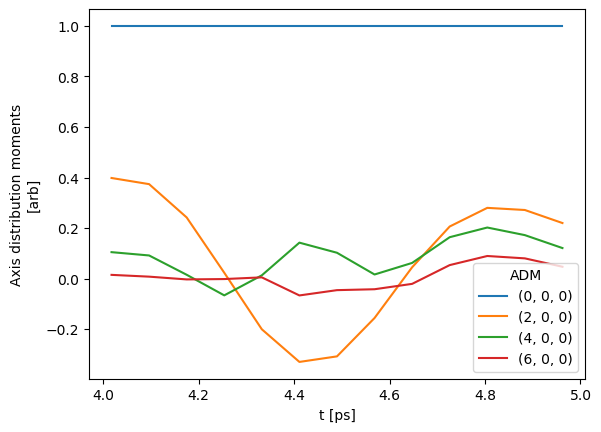

In [20]:
# And for the ADMs...

data.selOpts['ADM'] = {}   #{'thres': 0.01, 'inds': {'Type':'L', 'Eke':1.1}}
data.setSubset(dataKey = 'ADM', dataType = 'ADM', sliceParams = {'t':[4, 5, 4]}) 
data.ADMplot(keys = 'subset')

In [21]:
# Cusomise plot with return...
# NOT YET IMPLEMENTED
# pltObj = data.ADMplot(keys = 'subset')
# pltObj

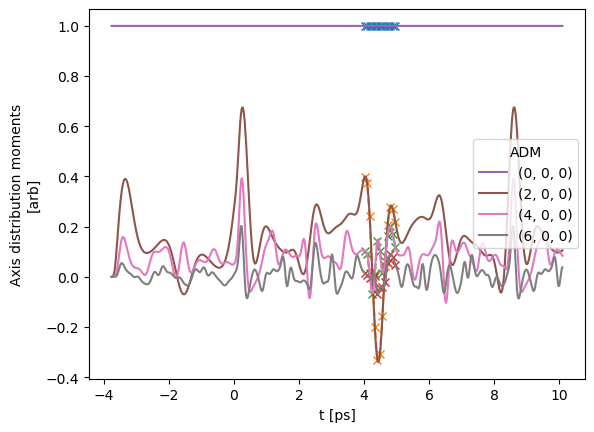

In [22]:
# Plot from Xarray vs. full dataset
# data.data['subset']['ADM'].where(ADMX['K']>0).real.squeeze().plot.line(x='t');
data.data['subset']['ADM'].real.squeeze().plot.line(x='t', marker = 'x', linestyle='dashed');
data.data['ADM']['ADM'].real.squeeze().plot.line(x='t');

## Compute AF-$\beta_{LM}$ and simulate data

With all the components set, some observables can be calculated. For testing, we'll also use this to simulate an experiemental trace...

Here we'll use `self.afblmMatEfit()`, which is also the main fitting routine, and essentially wraps `epsproc.afblmXprod()` to compute AF-$\beta_{LM}$s (for more details, see the [ePSproc method development docs](https://epsproc.readthedocs.io/en/dev/methods/geometric_method_dev_pt3_AFBLM_090620_010920_dev_bk100920.html)).

If called without reference data, the method returns computed AF-$\beta_{LM}$s based on the input subsets already created, and also a set of (product) basis functions generated - these can be examined to get a feel for the sensitivity of the geometric part of the problem, and will also be used in fitting to limit repetitive computation.

### Compute AF-$\beta_{LM}$s

In [23]:
# data.afblmMatEfit(data = None)  # OK
BetaNormX, basis = data.afblmMatEfit()  # OK, uses default polarizations & ADMs as set in data['subset']
# BetaNormX, basis = data.afblmMatEfit(ADM = data.data['subset']['ADM'])  # OK, but currently using default polarizations
# BetaNormX, basis = data.afblmMatEfit(ADM = data.data['subset']['ADM'], pol = data.data['pol']['pol'].sel(Labels=['x']))
# BetaNormX, basis = data.afblmMatEfit(ADM = data.data['subset']['ADM'], pol = data.data['pol']['pol'].sel(Labels=['x','y']))  # This fails for a single label...?
# BetaNormX, basis = data.afblmMatEfit(RX=data.data['pol']['pol'])  # This currently fails, need to check for consistency in ep.sphCalc.WDcalc()
                                                                    # - looks like set values and inputs are not consistent in this case? Not passing angs correctly, or overriding?
                                                                    # - See also recently-added sfError flag, which may cause additional problems.


### AF-$\beta_{LM}$s

The returned objects contain the $\beta_{LM}$ parameters as an Xarray...

In [24]:
BetaNormX

<xarray.DataArray (Labels: 1, t: 13, BLM: 15)>
array([[[ 0.00000000e+00+0.00000000e+00j,
          1.66882312e+00+5.78828173e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          9.25154735e-01-2.04255472e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.45626494e-01-2.50162312e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          9.05679279e-03+2.69005757e-19j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.65939046e+00-7.23129056e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          9.28209270e-01-1.20305969e-17j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.35884180e-01+7.60995910e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          7.87360160e-03-5.26232236e-19j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.60819595e+00+5.37946903e-19j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          9.44773203e-01+2.80576809e-17j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -8.24684513e-02-1.29331051e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          1.24796733e-03+1.99111244e-19j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.52326324e+00-1.50526506e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          9.72371636e-01+7.27400639e-19j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          4.93224211e-04+1.20678198e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -5.69662854e-03-1.12782141e-19j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.43634451e+00+9.52773406e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          1.00104159e+00+2.33569626e-17j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          6.53535497e-02-2.06092931e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          1.13815711e-03-3.50093184e-18j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.38620024e+00+9.20243198e-19j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          1.01780024e+00-1.33980425e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          9.28414140e-02+2.05936950e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          1.15029998e-02-1.86868078e-18j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.39472246e+00-4.45373740e-18j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,

Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=a, thres=0.01, with Seaborn


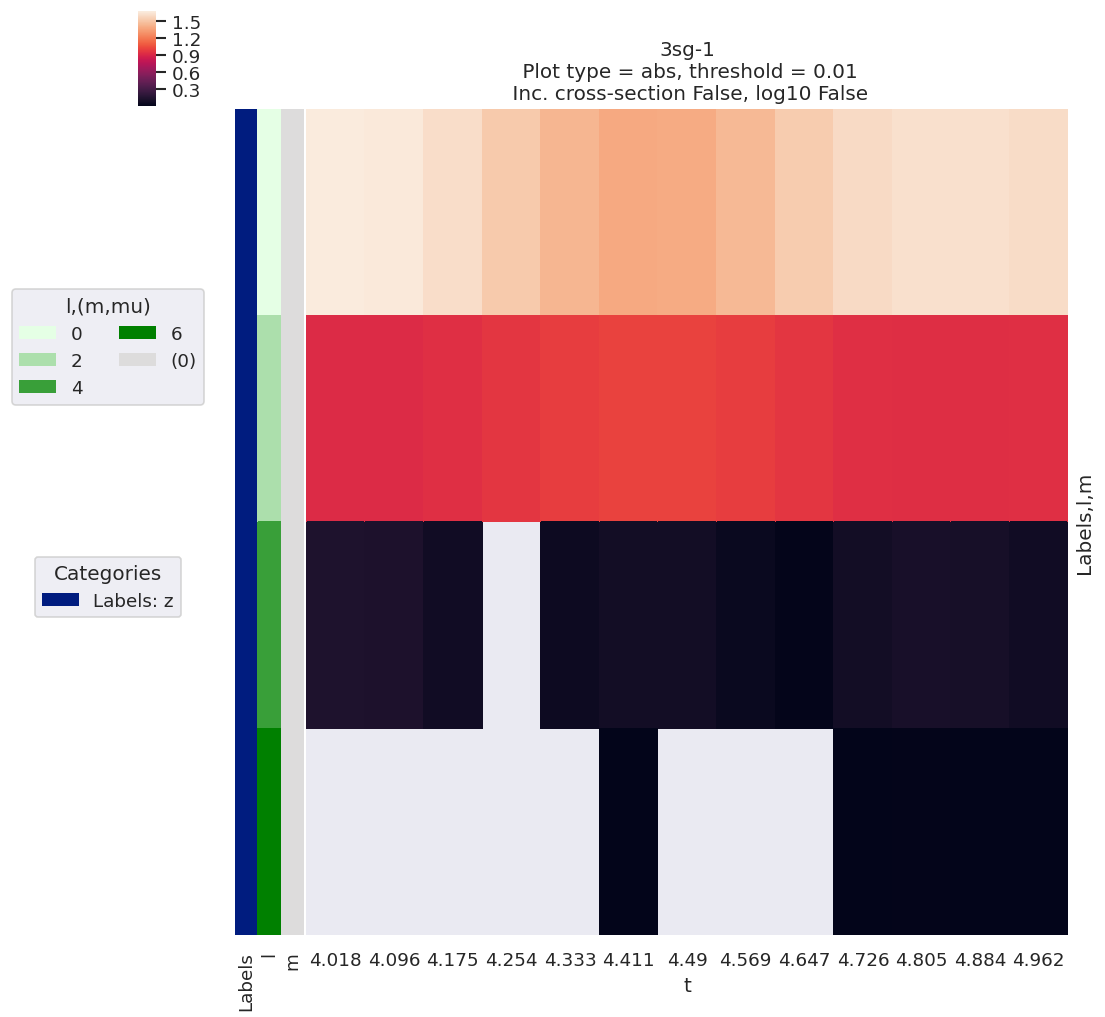

In [25]:
# ep.BLMplot(BetaNormX, xDim = 't')  # SIGH, not working - issue with Euler/Labels?
# BetaNormX.sel(Labels='z').real.squeeze().plot.line(x='t');
# ep.lmPlot(BetaNormX.sel(Labels='z'), xDim='t', SFflag=False);  #, cmap='vlag');
ep.lmPlot(BetaNormX, xDim='t', SFflag=False);
# data.lmPlot()

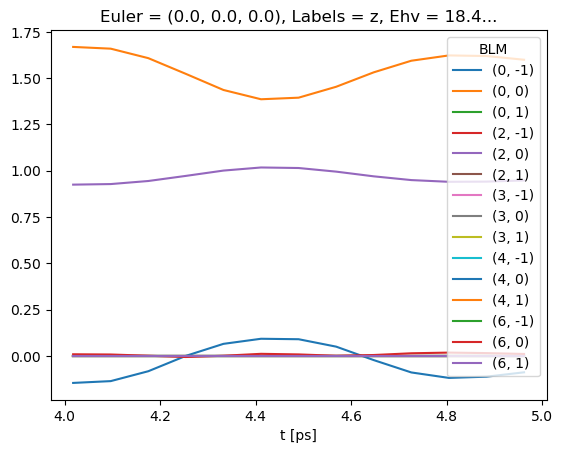

In [26]:
# Line-plot with Xarray/Matplotlib
# Note there is no filtering here, so this includes some invalid and null terms
BetaNormX.sel(Labels='z').real.squeeze().plot.line(x='t');

... and the basis sets as a dictionary.

In [27]:
basis.keys()

dict_keys(['BLMtableResort', 'polProd', 'phaseConvention', 'BLMRenorm'])

Note that the basis sets here will may be useful for deeper insight into the physics, and fitting routines, and are explored in a separate notebook.

## Fitting the data

In order to fit data, and extract matrix elements from an experimental case, we'll use the [lmfit library](https://lmfit.github.io/lmfit-py/intro.html). This wraps core Scipy fitting routines with additional objects and methods, and is further wrapped for this specific class of problems in `pemtkFit` class we're using here.

### Set the data to fit

Here we'll use the values calculated above as our test data. This currently needs to be set as `self.data['subset']['AFBLM']` for fitting.

In [28]:
# data.data['subset']['AFBLM'] = BetaNormX  # Set manually

data.setData('sim', BetaNormX)  # Set simulated data to master structure as "sim"
data.setSubset('sim','AFBLM')   # Set to 'subset' to use for fitting.


Subselected from dataset 'sim', dataType 'AFBLM': 195 from 195 points (100.00%)


In [29]:
# Set basis functions
data.basis = basis

### Setting up the fit parameters

In this case, we can work from the existing matrix elements to speed up parameter creation, although in practice this may need to be approached ab initio - nonetheless, the method will be the same, and the ab initio case detailed later.

In [30]:
# Input set, as defined earlier
data.data['subset']['matE'].pd

Cont  Targ  Total  it  l  m   mu
PU    SG    PU     1   1  -1   1    1.162941-1.353670j
                           1  -1    1.162941-1.353670j
                       3  -1   1   -0.802725-0.016979j
                           1  -1   -0.802725-0.016979j
SU    SG    SU     1   1   0   0   -2.317060+1.358736j
                       3   0   0    1.105722-0.087176j
dtype: complex128

In [31]:
# data.setMatEFit()  # Need to fix self.subset usage
data.setMatEFit(data.data['subset']['matE'])  #, Eke=1.1) # Some hard-coded things to fix here! Now roughly working.

Set 6 complex matrix elements to 12 fitting params, see self.params for details.


name,value,initial value,min,max,vary
m_PU_SG_PU_1_n1_1,1.78461575,1.784615753610107,1.0000e-04,5.00000000,True
m_PU_SG_PU_1_1_n1,1.78461575,1.784615753610107,1.0000e-04,5.00000000,True
m_PU_SG_PU_3_n1_1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,True
m_PU_SG_PU_3_1_n1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,True
m_SU_SG_SU_1_0_0,2.68606212,2.686062120382649,1.0000e-04,5.00000000,True
m_SU_SG_SU_3_0_0,1.10915311,1.109153108617096,1.0000e-04,5.00000000,True
p_PU_SG_PU_1_n1_1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,False
p_PU_SG_PU_1_1_n1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,True
p_PU_SG_PU_3_n1_1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,True
p_PU_SG_PU_3_1_n1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,True


This sets `self.params` from the matrix elements, which are a set of (real) parameters for lmfit, as [a Parameters object](https://lmfit.github.io/lmfit-py/parameters.html). 

Note that: 

- The input matrix elements are converted to magnitude-phase form, hence there are twice the number as the input array, and labelled `m` or `p` accordingly, along with a name based on the full set of QNs/indexes set.
- One phase is set to `vary=False`, which defines a reference phase. This defaults to the first phase item.
- Min and max values are defined, by default the ranges are 1e-4<mag<5, -pi<phase<pi.
- No relationships between the parameters are set by default (apart from the single fixed phase), but can be set manually, [see section below](http://127.0.0.1:8888/lab/workspaces/pemtk#Setting-parameter-relations).

In [32]:
data.params

name,value,initial value,min,max,vary
m_PU_SG_PU_1_n1_1,1.78461575,1.784615753610107,1.0000e-04,5.00000000,True
m_PU_SG_PU_1_1_n1,1.78461575,1.784615753610107,1.0000e-04,5.00000000,True
m_PU_SG_PU_3_n1_1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,True
m_PU_SG_PU_3_1_n1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,True
m_SU_SG_SU_1_0_0,2.68606212,2.686062120382649,1.0000e-04,5.00000000,True
m_SU_SG_SU_3_0_0,1.10915311,1.109153108617096,1.0000e-04,5.00000000,True
p_PU_SG_PU_1_n1_1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,False
p_PU_SG_PU_1_1_n1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,True
p_PU_SG_PU_3_n1_1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,True
p_PU_SG_PU_3_1_n1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,True


### Running a fit...

With the parameters and data set, just call `self.fit()`!

Statistics and outputs are handled by lmfit, which includes uncertainty estimates and correlations in the fitted parameters.

In [33]:
data.fit()

In [34]:
# Check fit outputs
data.result

Results vs. data can be (crudely) plotted with `self.BLMfitPlot()` (better plotting routines to follow!).

This will plot all results by default, vs. the `subset` data used for the fitting routine inputs.

Dataset: subset, AFBLM
Dataset: 0, AFBLM


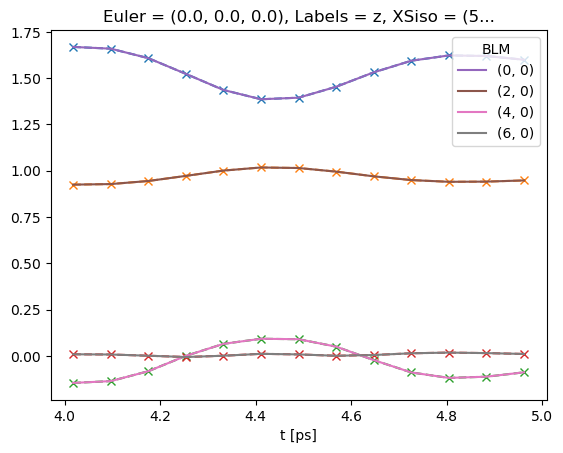

In [35]:
# Plot data subset (--x) plus fit (solid lines)
data.BLMfitPlot()

In [36]:
# Fit results are currently added to the main data dict by an index number
data.data.keys()

dict_keys(['orb6', 'orb5', 'ADM', 'pol', 'subset', 'sim', 0])

Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=a, thres=0.01, with Seaborn
Plotting data (No filename), pType=a, thres=0.01, with Seaborn


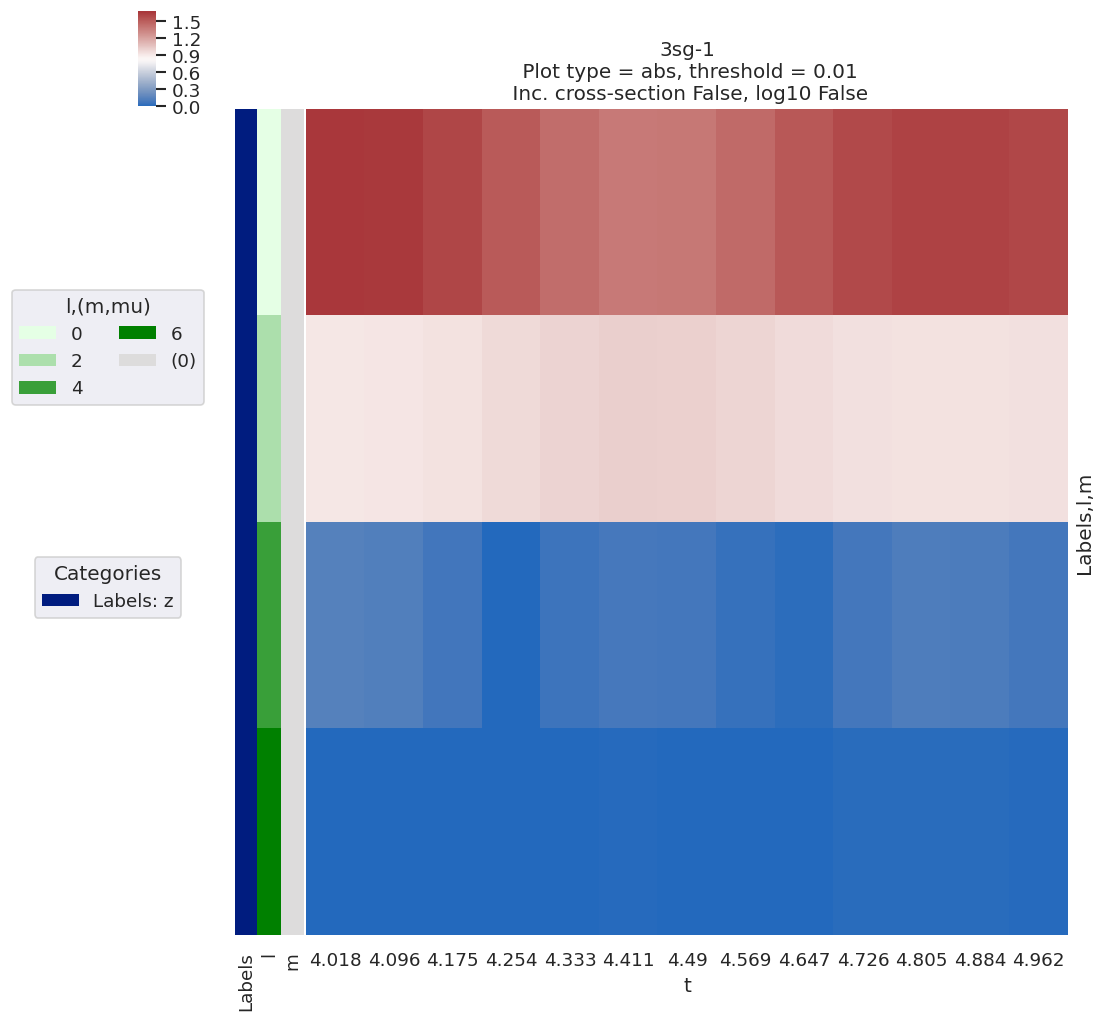

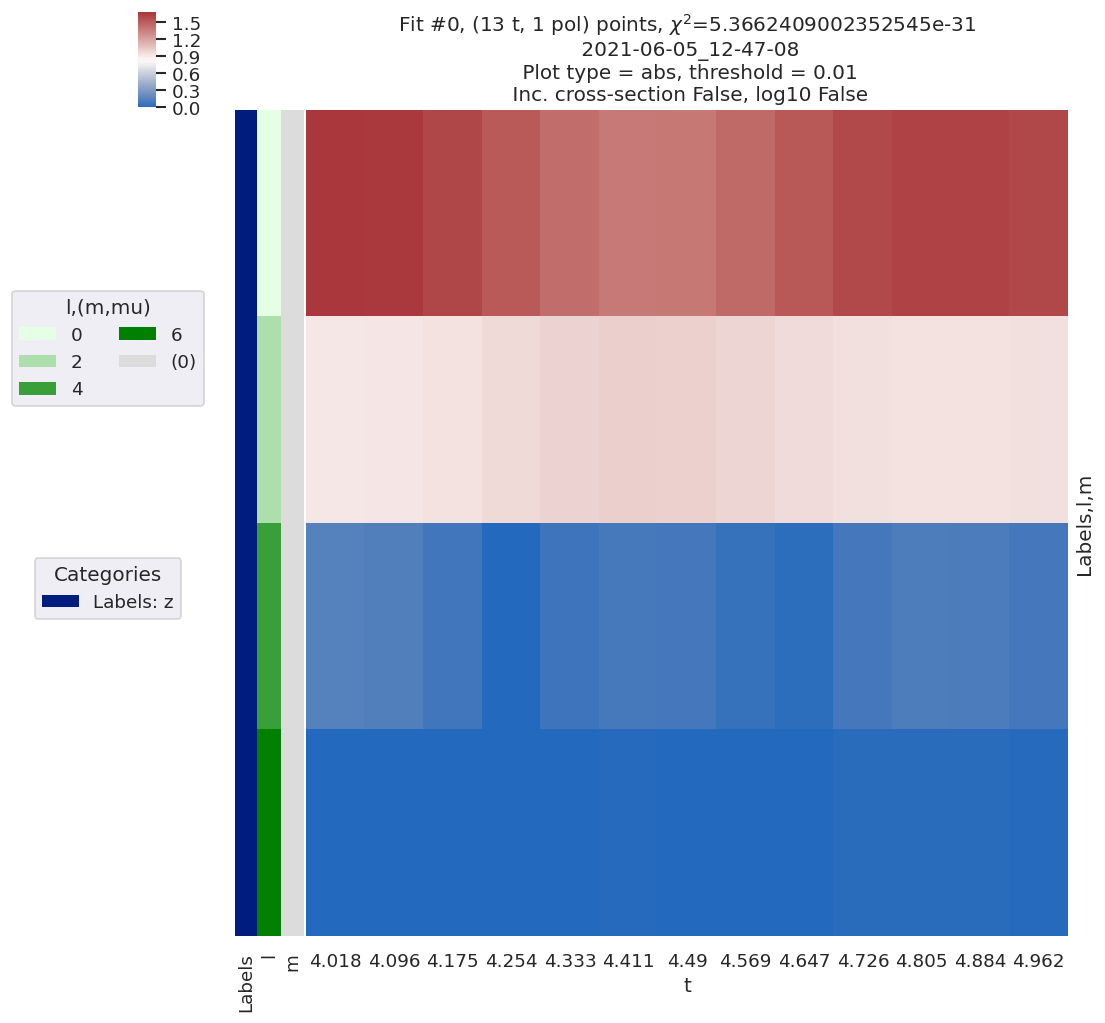

In [37]:
# Plot results with lmPlot wrapper - this also defaults to show data subset + most recent fit results
data.lmPlotFit()

### Fitting with randomised parameter inputs

Here we might expect some variation in the results, depending on various properites (ionizing channel, dataset size etc.), and also for the fitting to take a bit longer (see benchmarks later).

TODO: 

- More careful analysis routines here, run vs. number of input points & test fiedelity.
- Parallelize.
- Variation over runs/general statistical analysis.

In [38]:
# Basic randomize routine, [0,1] interval
data.randomizeParams()

In [39]:
data.fit()
data.result

Dataset: subset, AFBLM
Dataset: 1, AFBLM


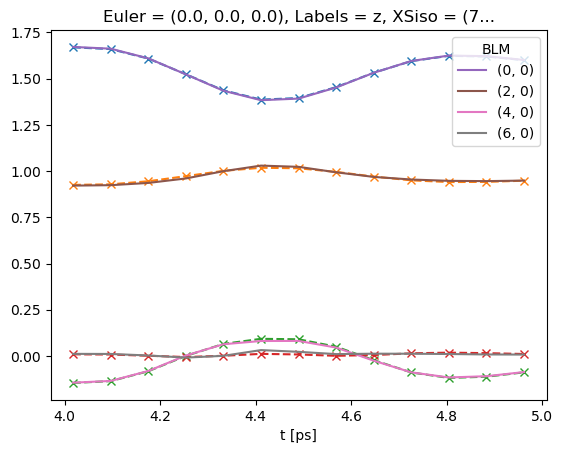

In [40]:
# Note that if keys is not set, BLMfitPlot will show all fit run results.
data.BLMfitPlot()

#### Quick benchmark - basic fit

Timing for the test fit (next cell) - note this is currently just running with defaults, single core only, and we're not checking for good fiedelity here. Fits take between 1 and 12 mins, approximately.

Results may vary depending on the inputs... for the current test case:

- 1st test
    The slowest run took 12.88 times longer than the fastest. This could mean that an intermediate result is being cached.
    50.7 s ± 1min 2s per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 2nd test
    The slowest run took 105.38 times longer than the fastest. This could mean that an intermediate result is being cached.
    4min 13s ± 7min 6s per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
    
TODO:

- More careful testing & benchmarks.
- Timing vs. input dataset size.
- Fitting statistics over fits (fidelity vs. fit vs. dataset size etc.).

In [41]:
# %%timeit

# data.randomizeParams()
# data.fit()

### Setting parameter relations/constraints

If we know that some of the matrix elements (parameters) are related, this can be set [using contraints on the parameters](https://lmfit.github.io/lmfit-py/constraints.html).

In this test case, we know some terms are equal... this should speed up the fitting, and also improve fiedelity.

TODO: automatic relation setting in cases derived from computational matrix elements.

In [42]:
# With constraints
# Set param constraints as dict
paramsCons = {}
paramsCons['m_PU_SG_PU_1_n1_1'] = 'm_PU_SG_PU_1_1_n1'
paramsCons['p_PU_SG_PU_1_n1_1'] = 'p_PU_SG_PU_1_1_n1'

paramsCons['m_PU_SG_PU_3_n1_1'] = 'm_PU_SG_PU_3_1_n1'
paramsCons['p_PU_SG_PU_3_n1_1'] = 'p_PU_SG_PU_3_1_n1'

data.setMatEFit(paramsCons = paramsCons)

Set 6 complex matrix elements to 12 fitting params, see self.params for details.


name,value,initial value,min,max,vary,expression
m_PU_SG_PU_1_n1_1,1.78461575,1.784615753610107,1.0000e-04,5.00000000,False,m_PU_SG_PU_1_1_n1
m_PU_SG_PU_1_1_n1,1.78461575,1.784615753610107,1.0000e-04,5.00000000,True,
m_PU_SG_PU_3_n1_1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,False,m_PU_SG_PU_3_1_n1
m_PU_SG_PU_3_1_n1,0.80290495,0.802904951323892,1.0000e-04,5.00000000,True,
m_SU_SG_SU_1_0_0,2.68606212,2.686062120382649,1.0000e-04,5.00000000,True,
m_SU_SG_SU_3_0_0,1.10915311,1.109153108617096,1.0000e-04,5.00000000,True,
p_PU_SG_PU_1_n1_1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,False,p_PU_SG_PU_1_1_n1
p_PU_SG_PU_1_1_n1,-0.86104140,-0.8610414024232179,-3.14159265,3.14159265,True,
p_PU_SG_PU_3_n1_1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,False,p_PU_SG_PU_3_1_n1
p_PU_SG_PU_3_1_n1,-3.12044446,-3.1204444620772467,-3.14159265,3.14159265,True,


In [43]:
data.randomizeParams()
data.fit()
data.result

Dataset: subset, AFBLM
Dataset: 2, AFBLM


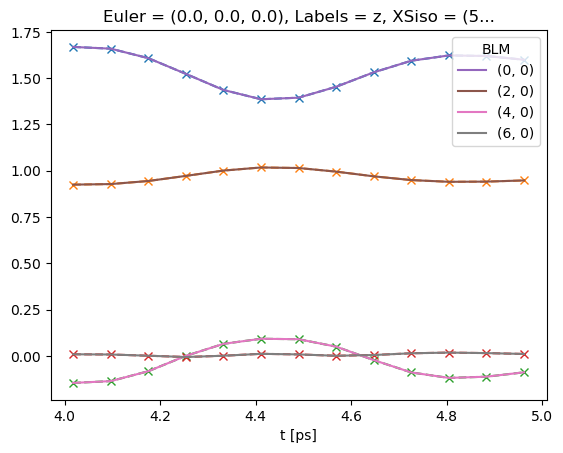

In [44]:
# Note that if keys is not set, BLMfitPlot will show only most recent fit run results.
data.BLMfitPlot()

#### Quick benchmark - constrained fit

Timing for the test fit (next cell, same [method as earlier](http://127.0.0.1:8888/lab/workspaces/pemtk#Quick-benchmark---basic-fit)) - note this is currently just running with defaults, single core only, and we're not checking for good fiedelity here. Note, also, that these results are in the ~10s range, compared to ~many minutes for the unconstrained case.

- 1st test
    10.7 s ± 2.86 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 2nd test 7.9 s ± 3.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit

data.randomizeParams()
data.fit()

The slowest run took 7.96 times longer than the fastest. This could mean that an intermediate result is being cached.
17.8 s ± 17.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Dataset: subset, AFBLM
Dataset: 0, AFBLM
Dataset: 1, AFBLM
Dataset: 2, AFBLM
Dataset: 3, AFBLM
Dataset: 4, AFBLM
Dataset: 5, AFBLM
Dataset: 6, AFBLM
Dataset: 7, AFBLM
Dataset: 8, AFBLM
Dataset: 9, AFBLM
Dataset: 10, AFBLM


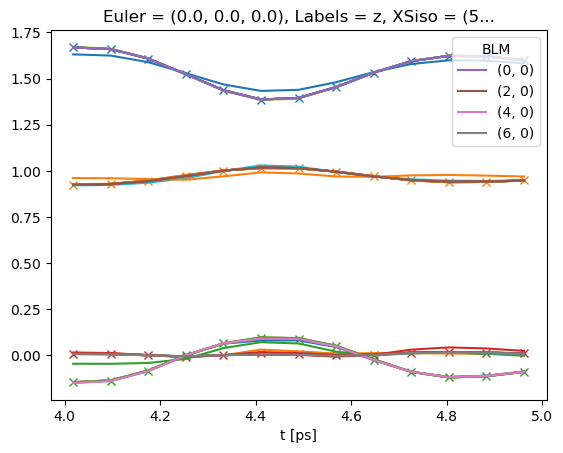

In [46]:
# Plot multiple fit sets
# Note that if keys = 'all' is set, BLMfitPlot will show ALL fit run results.
# TODO: use Seaborn/HV for better plotting here!
data.BLMfitPlot(keys = 'all')

## Versions

In [47]:
import scooby
scooby.Report(additional=['epsproc', 'pemtk', 'xarray', 'jupyter'])

--------------------------------------------------------------------------------
  Date: Sat Jun 05 12:49:56 2021 Eastern Daylight Time

                OS : Windows
            CPU(s) : 32
           Machine : AMD64
      Architecture : 64bit
               RAM : 63.9 GB
       Environment : Jupyter

  Python 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]

           epsproc : 1.3.0-dev
             pemtk : 0.0.1
            xarray : 0.15.0
           jupyter : Version unknown
             numpy : 1.19.2
             scipy : 1.3.0
           IPython : 7.12.0
        matplotlib : 3.3.1
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191125 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

In [48]:
# Check current Git commit for local ePSproc version
!git -C {Path(ep.__file__).parent} branch
!git -C {Path(ep.__file__).parent} log --format="%H" -n 1

* dev
  master
  numba-tests
da12376cc36f640d8974f5ce2c121be3d391caab


In [49]:
# Check current remote commits
!git ls-remote --heads git://github.com/phockett/ePSproc
# !git ls-remote --heads git://github.com/phockett/epsman

da12376cc36f640d8974f5ce2c121be3d391caab	refs/heads/dev
82d12cf35b19882d4e9a2cde3d4009fe679cfaee	refs/heads/master
69cd89ce5bc0ad6d465a4bd8df6fba15d3fd1aee	refs/heads/numba-tests
ea30878c842f09d525fbf39fa269fa2302a13b57	refs/heads/revert-9-master


In [50]:
# Check current Git commit for local PEMtk version
import pemtk
!git -C {Path(pemtk.__file__).parent} branch
!git -C {Path(pemtk.__file__).parent} log --format="%H" -n 1

* master
fca744ca18b98ecd49fbf17fc79247ebee6b9c3a


In [51]:
# Check current remote commits
!git ls-remote --heads git://github.com/phockett/PEMtk
# !git ls-remote --heads git://github.com/phockett/epsman

fca744ca18b98ecd49fbf17fc79247ebee6b9c3a	refs/heads/master
